In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import mmread

from scipy.sparse.linalg import cg, spilu, LinearOperator, aslinearoperator
from scipy.sparse import isspmatrix, csr_matrix, tril, diags

In [15]:
#A = mmread('s3dkq4m2.mtx')
# Function to create matrix A
def generate_matrix_A(n):
    diagonals = [
        -1 * np.ones(n - 1),  # Lower diagonal
        2 * np.ones(n),       # Main diagonal
        -1 * np.ones(n - 1)   # Upper diagonal
    ]
    
    # Create the sparse matrix
    A = diags(diagonals, offsets=[-1, 0, 1], format='csr')
    
    # Adjust the last diagonal element
    A[-1, -1] = 1  # Update the last diagonal element directly in the sparse matrix
    
    return A

In [16]:
# Function to create matrix B
def generate_vector_b(n):
    b = np.zeros(n)
    b[0] = 1
    return b

In [17]:
A= generate_matrix_A(100)

In [18]:
n= A.shape[0]
b= generate_vector_b(n)

In [19]:
def preconditioned_conjugate_gradient(A, b, M_inv,max_iter,tol=1e-6):
    """
    Solves Ax = b using the preconditioned conjugate gradient method.

    Parameters:
    - A: Coefficient matrix (NxN).
    - b: Right-hand side vector (Nx1).
    - M_inv: Inverse of the preconditioner matrix (NxN).
    - tol: Tolerance for the stopping criterion.
    - max_iter: Maximum number of iterations.

    Returns:
    - x: Solution vector (Nx1).
    - k: Number of iterations performed.
    """
    # Initialization
    k = 0
    x = np.zeros_like(b)  # Initial guess x0 = 0
    r = b - A @ x         # Initial residual r0 = b - Ax0
    y = M_inv @ r         # Preconditioned residual y0 = M_inv * r0
    p = y.copy()          # Initial direction p1 = y0
    mu_prev = np.dot(r.T, y)  # Initial mu = r0.T @ y0

    for k in range(1, max_iter + 1):
        z = A @ p
        nu = mu_prev / (p.T @ z)
        x = x + nu * p
        r = r - nu * z

        if np.linalg.norm(r) < tol:
            break

        y = M_inv @ r
        mu = np.dot(r.T, y)
        beta = mu / mu_prev
        p = y + beta * p
        mu_prev = mu

    return x, k

In [20]:
from scipy.sparse.linalg import LinearOperator

# Define a Jacobi preconditioner
def jacobi_preconditioner(A):
    """
    Returns a LinearOperator that represents the Jacobi preconditioner.
    """
    diag = A.diagonal()  # Extract the diagonal elements
    def apply_preconditioner(x):
        return x / diag  # Divide vector x element-wise by the diagonal
    return LinearOperator(A.shape, matvec=apply_preconditioner)

In [21]:
# Create the Jacobi preconditioner
M_inv = jacobi_preconditioner(A)

# Solve the system
x, num_iterations = preconditioned_conjugate_gradient(A, b, M_inv, max_iter=n)
#print("Solution:", x)
print("Number of iterations:", num_iterations)

Number of iterations: 100


In [22]:
residual = b - A @ x
error_norm = np.linalg.norm(residual)
print("Residual norm:", error_norm)

Residual norm: 7.331676146681978e-15


In [23]:
def ichol_sparse_optimized(A): #final version
    """
    Optimized Incomplete Cholesky factorization for a sparse matrix A.
    A should be a symmetric positive definite matrix in CSR format.
    """
    A = A.tocsr()  # Ensure A is in CSR format
    n = A.shape[0]
    L = A.copy()   # Create a copy of A to store the result

    for k in range(n):
        # Update the diagonal element
        L[k, k] = np.sqrt(L[k, k])
        
        # Update column k below the diagonal
        rows = L.indices[L.indptr[k] : L.indptr[k + 1]]
        rows = rows[rows > k]  # Only consider rows below the diagonal
        
        if rows.size > 0:
            L[rows, k] /= L[k, k]

        # Update the lower-right submatrix
        for i in rows:
            L[i, rows] -= L[i, k] * L[rows, k]
    
    # Extract the lower triangular part of L
    L = tril(L, format='csr')
    return L


In [24]:
def ichol_preconditioner(A):
    """
    Compute the preconditioner using Incomplete Cholesky.
    Returns a function to apply M_inv = L^-1 * L^-T to a vector.
    """
    # Compute the Incomplete Cholesky factorization
    L = ichol_sparse_optimized(A)
    
    # Define a function to apply M_inv = (L^-1)(L^-T)
    def apply_preconditioner(v):
        # Solve L * y = v (forward substitution)
        y = spsolve(L, v)
        # Solve L.T * z = y (backward substitution)
        z = spsolve(L.T, y)
        return z
    
    # Return as a LinearOperator for compatibility
    n = A.shape[0]
    M_inv = LinearOperator((n, n), matvec=apply_preconditioner)
    return M_inv


In [25]:
A= generate_matrix_A(10)
n= A.shape[0]
b= generate_vector_b(n)

In [26]:
from scipy.sparse.linalg import spsolve, LinearOperator
from scipy.sparse import tril
# Compute the preconditioner
M_inv = ichol_preconditioner(A)

# Solve the system
x, num_iterations = preconditioned_conjugate_gradient(A, b, M_inv,max_iter=n)
#print("Solution:", x)
print("Number of iterations:", num_iterations)

Number of iterations: 1


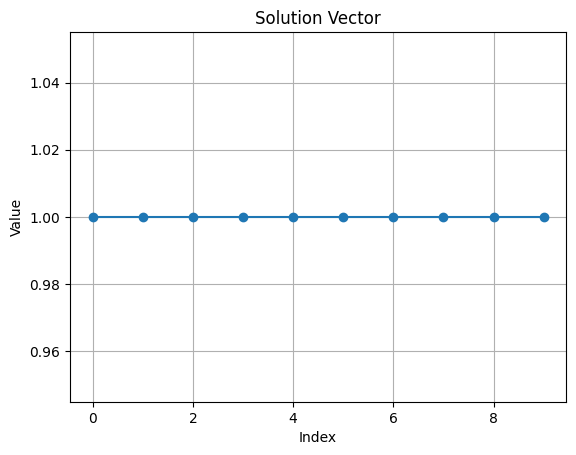

In [27]:
x = np.round(x,2)
plt.plot(x, marker='o', linestyle='-')
plt.title("Solution Vector")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.show()